# Gradient Methods in Convex Optimization

<font color='green'> This practical session concerns the convergence analysis of various first-order optimization methods. Our main objectives are the following:
</font>
- <font color='green'>gaining familiarity with Tensorflow's automatic differentiation engine;</font>
- <font color='green'>introducing a potential-based strategy to prove convergence of gradient methods under a variety of different assumptions;</font>
- <font color='green'>understanding the role of smoothness in speeding up convergence;</font>
- <font color='green'>introducing Nesterov's acceleration;</font>
- <font color='green'>demonstrating an example where mirror descent offers faster convergence speed;</font>
- <font color='green'>discussing the role of variance in stochastic gradient descent;</font>
- <font color='green'>presenting intuitive ideas behind modern variance-reduction techniques.</font>

In this notebook, we take a look at some first-order methods in convex optimization. We begin by investigating the performance of gradient descent for Lipschitz and smooth functions, as well as taking a look at a variant of Nesterov's accelerated method that achieves the optimal convergence rate for smooth functions. In the second part of this notebook (exercises 5 and 6), we turn to the extensions to non-Euclidean and stochastic settings. One of the primary aims of this notebook is to present a potential-based proof technique that allows us to analyze the convergence of all the presented methods within an elegant and unified framework. Various references are collected at the end of this notebook.


## Automatic Differentiation via Tensorflow

Before starting with our gradient descent simulations, let us introduce some of the functionality offered by Tensorflow (refer [here](https://www.tensorflow.org/api_docs/python/tf/) for the documentation) that will help simplify our code.
First, run the below cell to import all the packages to be used in this notebook.


In [1]:
import numpy as np # For manimpulating arrays.
from matplotlib import pyplot as plt # For potting.
import tensorflow as tf # For automatically computing gradients.
import tensorflow.experimental.numpy as tnp # Allows to handle tensorflow's
                                            # Tensors with numpy-compatible API.
tnp.experimental_enable_numpy_behavior()

While we will not use the full functionality offered by Tensorflow, of particular importance to us is the automatic differentiation engine. The below code cell provides an example of how a `tf.GradientTape` can be combined with `tf.Variable` to compute gradients automatically.

In [2]:
x = tf.Variable(-4.0)
f = lambda x : tnp.abs(x) # Note the use of tnp instead of np.
with tf.GradientTape() as tape:
  # GradientTape automatically watches gradients of tf.Variable objects.
  fx = f(x)
df_dx = tape.gradient(fx, x)
print("f'(x) =", df_dx.numpy(), "at x =", x.numpy())

f'(x) = -1.0 at x = -4.0


The below code cell demonstrates how Tensorflow's implementation of gradient descent optimizer can be used to perform gradient descent updates. For available optimizers see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers.

In [3]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("First approach:")
x = tf.Variable(0.0)
print("x0 =", x.numpy())
f = lambda x : (x-1)**2
with tf.GradientTape() as tape:
  fx = f(x)
df_dx = tape.gradient(fx, x)
# The below cell performs the update x -= learning_rate * f'(x).
optimizer.apply_gradients(zip([df_dx], [x]))
print("x1 =", x.numpy())

# The above code can be simplified by calling optimizer.minimize method,
# which internaly runs the above code involving GradientTape.
print()
print("Second approach:")
x = tf.Variable(0.0)
print("x0 =", x.numpy())
optimizer.minimize(lambda : f(x), [x])
print("x1 =", x.numpy())

First approach:
x0 = 0.0
x1 = 0.02

Second approach:
x0 = 0.0
x1 = 0.02


Instead of relying on the optimizers already implemented by the Tensorflow library, in this practical session, we create our own abstract base class `Optimizer` for gradient-based optimization algorithms. To implement variations of different optimizers, we will need to implement the `apply_gradient` method defined below. 

In [4]:
class Optimizer(object):
  """ A base class for optimizers. """

  def __init__(self, eta):
    """ :eta_t: A function taking as argument the current iteration t and
          returning the step size eta_t to be used in the current iteration. """
    super().__init__()
    self.eta = eta
    self.t = 0 # Set iterations counter.

  def apply_gradient(self, x_t, g_t):
    """ Given the current iterate x_t and gradient g_t, updates the value
      of x_t to x_(t+1) by performing one iterative update.
        :x_t: A tf.Variable which value is to be updated.
        :g_t: The gradient value, to be used for performing the update.
    """
    raise NotImplementedError("To be implemented by subclasses.")

  def step(self, f, x_t):
    """ Updates the variable x_t by performing one optimization iteration.
        :f: A function which is being minimized.
        :x_t: A tf.Variable with respect to which the function is being
          minimized and which value is to be updated.
    """
    with tf.GradientTape() as tape:
      fx = f(x_t)
    g_t = tape.gradient(fx, x_t)
    self.apply_gradient(x_t, g_t)
    # Update the iterations counter.
    self.t += 1

  def optimize(self, f, x_t, n_iterations):
    """ Applies the function step n_iterations number of times, starting from
      the iterate x_t. Note: the number of iterations member self.t is not
      restarted to 0, which may affects the computed step sizes. 
        :f: Function to optimize.
        :x_t: Current iterate x_t.
        :returns: A list of length n_iterations+1, containing the iterates
          [x_t, x_{t+1}, ..., x_{t+n_iterations}].
    """
    x = tf.Variable(x_t)
    iterates = []
    iterates.append(x.numpy().reshape(-1,1))
    for _ in range(n_iterations):
      self.step(f, x)
      iterates.append(x.numpy().reshape(-1,1))
    return iterates

In the below code cell we implement `apply_gradient` method for gradient descet
updates
$$
  x_{t+1} = x_{t} - \eta_{t} \nabla f(x_{t}).
$$

In [5]:
class GradientDescent(Optimizer):
  """ An implementation of gradient descent uptades. """

  def apply_gradient(self, x_t, g_t):
    eta_t = self.eta(self.t)
    x_t.assign_add(-eta_t * g_t)

We can now run our `GradientDescent` optimizer and verify if we generate the same sequence as the one using the internal implementation provided by Tensorflow.

In [6]:
f = lambda x : (x-1)**2

eta = 0.01
our_opt = GradientDescent(eta = lambda t : eta)
tensorflow_opt = tf.keras.optimizers.SGD(learning_rate=eta)

n_iterations = 5
print("Running gradient descent by using:", our_opt.__class__)
x = tf.Variable(0.0)
iterates = our_opt.optimize(f, x, 5)
for idx in range(len(iterates)):
  print("x"+str(idx)+" =", iterates[idx].squeeze())

print()
print("Running gradient descent by using:", tensorflow_opt.__class__)
x = tf.Variable(0.0)
print("x0 =", x.numpy())
for idx in range(n_iterations):
  tensorflow_opt.minimize(lambda : f(x), [x])
  print("x"+str(idx+1)+" =", x.numpy())

Running gradient descent by using: <class '__main__.GradientDescent'>
x0 = 0.0
x1 = 0.02
x2 = 0.0396
x3 = 0.058808
x4 = 0.07763184
x5 = 0.0960792

Running gradient descent by using: <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>
x0 = 0.0
x1 = 0.02
x2 = 0.0396
x3 = 0.058808
x4 = 0.07763184
x5 = 0.0960792


## Convergence of Gradient Descent

Now that we have an implementation of the gradient descent optimizer ready, let us recall its continuous-time convergence analysis, which will serve as a template for discrete-time analyses. The continuous-time gradient descent flow
is given by
$$
  \frac{d}{dt}x_{t} = -\eta \nabla f(x_{t}),
$$
where $f : \mathbb{R}^{d} \to \mathbb{R}$ is convex. Let $x^{\star}$ denote any global minimizer of $f$.
The key observation in the analysis to follow is the fact that at any point $x$, the negative gradient $-\nabla f(x)$ is pointing in the direction of $x^{\star}$. This can be formalized by noting that
$$
  \left\langle -\nabla f(x), x^{\star} - x \right\rangle
  \geq f(x) - f(x^{\star}) \geq 0,
$$
where the first inequality above follows from the convexity of $f$ and the second inequality follows since $x^{\star}$ is a global minimizer.

The above observation suggests that along the gradient flow, the Euclidean distance $\|x^{\star} - x_{t}\|_{2}$ is non-increasing. Indeed, looking at the squared Euclidean distance for mathematical convenience, we have
$$
  \underbrace{-\frac{d}{dt}\|x^{\star} - x_{t}\|_{2}^{2}}_{\text{change in potential}}
  = 2\left\langle \frac{d}{dt} x_{t}, x^{\star} - x_{t} \right\rangle
  = 2\left\langle -\eta \nabla f(x_{t}), x^{\star} - x_{t} \right\rangle
  \geq 2\eta(\underbrace{f(x_{t}) - f(x^{\star})}_{\text{sub-optimality gap}}).
  \tag{1}
$$
In words, the squared Euclidean distance $\|x^{\star} - x_{t}\|_{2}^{2}$ plays the role of a **potential function**. The above inequality shows that the at any time $T \in [0, \infty)$, the potential $\|x^{\star}-x_{T}\|_{2}^{2}$ is at most equal to the initial potential $\|x^{\star} - x_{0}\|_{2}^{2}$.
In addition, the right hand side of the above equation shows that the potential is decreasing at the rate proportional to the **sub-optimality gap** $f(x_{t}) - f(x^{\star})$. <font color='green'>**Since the potential is non-negative, it cannot keep decreasing indefinitely at a rate lower bounded by any positive constant, which in turn implies that $f(x_{t}) - f(x^{\star})$ has to converge to $0$.**</font>

The convergence rate can be obtained by integrating both sides of the above identity. For any $T \geq 0$, we have
\begin{align*}
  \|x^{\star} - x_{0}\|_{2}^{2}
  &\geq
  \|x^{\star} - x_{0}\|_{2}^{2} - \|x^{\star} - x_{T}\|_{2}^{2}
  \\
  &= \int_{0}^{T} -\frac{d}{dt}\|x^{\star} - x_{t}\|_{2}^{2}dt
  \\
  &\geq 2\eta
  \int_{0}^{T} (f(x_{t}) - f(x^{\star}))dt
  \\
  &= 2\eta T \left(
    \frac{1}{T}\int_{0}^{T} f(x_{t}) dt - f(x^{\star})
  \right).
\end{align*}
Let $\bar{x}_{T} = \frac{1}{T}\int_{0}^{T}x_{t}dt$. By convexity of $f$ we have
$f(\bar{x}_{T}) \leq \frac{1}{T}\int_{0}^{T}f(x_{t})dt$. Thus, rearranging the above chain of inequalities we can obtain convergence guarantees for the point $\bar{x}_{T}$ as well as for the optimal point visited along the path $(x_{t})_{0 \leq t \leq T}$:
$$
  \max\left\{
    \inf_{t \in [0,T]} f(x_{t}) - f(x^{\star}),
    f(\bar{x}_{T}) - f(x^{\star})
  \right\}
    \leq
    \frac{1}{T}\int_{0}^{T} f(x_{t}) dt - f(x^{\star})
    \leq \frac{\|x^{\star} - x_{0}\|_{2}^{2}}{2\eta T}. \tag{2}
$$

**Discrete-time analysis.** The above argument needs to undergo little change to handle discrete step sizes. Consider discrete gradient descent updates with varying step sizes $\eta_{t}$:
$$
  x_{t+1} = x_{t} - \eta_{t} \nabla f(x_{t}).
$$
We need to obtain a discrete-time equivalent of equation $(1)$. This can be done by noting that for any $a, b \in \mathbb{R}^{d}$ it holds that
$$
  \|a\|_{2}^{2} - \|a - b\|_{2}^{2} = 2\langle a, b\rangle - \|b\|_{2}^{2}.
$$
Letting $a = x^{\star} - x_{t}$ and $b = x_{t+1} - x_{t} = -\eta_{t} \nabla f(x_{t})$ yields the desired identity:
$$
  \|x^{\star} - x_{t}\|_{2}^{2} - \|x^{\star} - x_{t+1}\|_{2}^{2}
  = 2\eta_{t} \left\langle \nabla f(x_{t}), x^{\star} - x_{t} \right\rangle
  - \eta_{t}^{2}\|\nabla f(x_{t})\|_{2}^{2}.
$$
Repeating the continuous time analysis (replacing integrals by sums over $t=0, \dots, T$) yields
$$
  \min_{t=0,\dots,T} f(x_{t}) - f(x^{\star})
  \leq
  \frac{1}{\sum_{t=0}^{T} \eta_{t}}
  \sum_{t=0}^{T}\eta_{t}(f(x_{t}) - f(x^{\star}))
  \leq
  \underbrace{\frac{\|x^{\star} - x_{0}\|_{2}^{2}}{2\sum_{t=0}^{T}\eta_{t}}}_{
   \text{continuous-time rate} 
  }
  +
  \underbrace{\frac{\sum_{t=0}^{T}\eta_{t}^{2}\|\nabla f(x_{t})\|_{2}^{2}}
         {2\sum_{t=0}^{T}\eta_{t}}}_{\text{discretization error}}. \tag{3}
$$
Note that the above discrete-time guarantee is the same as the continuous-time one shown in equation $(2)$, modulo the discretization error term. <font color='green'>**The effect of this term is ultimately determined by additional regularity properties of the convex function $f$ that is being minimized.**</font> Below we will consider Lipschitzness and smoothness assumptions, but before that we turn to implementing some additional code that will help guide our analysis.


### Implementing Code to Track Convergence Metrics

We want to implement a function that given the output of a call to `optimizer.optimize`, computes the quantities involved in equation $(3)$. First, it will be convenient to wrap functions that we minimize into the below class, which supplies additional information such as access to a global minimizer $x^{\star}$.

In [7]:
class Function(object):
  """ A base class for functions that we will minimize. """

  def __init__(self, x_star):
    """ :x_star: A global minimizer of this function. """
    self.x_star = x_star
    self.f_star = self(self.x_star)

  def __call__(self, x):
    raise NotImplementedError("To be implemented by subclasses.")

Next, we implement a function that computes the quantities involved in $(3)$.

In [8]:
def compute_convergence_metrics(f, eta, iterates):
  """ A function that computes quantities involved in equation (3).

      :f: An object of type Function, which represents the function that is
        being minimized by the sequence of `iterates`.
      :eta: A function t -> \eta_{t} that was used in the computation of
        the provided iterates.
      :iterates: A list of iterates [x_0, x_1, ..., x_T] that were generated by
        a gradient descent update rule x_{t+1} = x_t - \eta_{t} \nabla f(x_t).
  """
  T = len(iterates)

  suboptimality_gaps = np.zeros(T-1) # The i-th element is \eta_i(f(x_i) - f(x*)).
  optimal_gap = np.zeros(T-1) # The left hand side of equation (3).
  weighted_gaps = np.zeros(T-1) # The middle term of equation (3).
  continous_time_rate = np.zeros(T-1) # See the RHS of equation (3).
  discretization_error = np.zeros(T-1) # See the RHS of equation (3).
  sum_of_etas = np.zeros(T-1)

  # The below loop pre-fills the above arrays. We will still need to
  # take cummulative sums and rescale some of the arrays by sum_of_etas.
  for t in range(T-1):
    sum_of_etas[t] = eta(t)
    x_t = iterates[t]
    suboptimality_gaps[t] = sum_of_etas[t] * (f(x_t) - f.f_star)

    # Compute the left hand side of (3).
    optimal_gap[t] = (f(x_t) - f.f_star)
    if t > 0:
      optimal_gap[t] = min(optimal_gap[t], optimal_gap[t-1])

    # A partial computation of the middle term of (3).
    weighted_gaps[t] = suboptimality_gaps[t]

    # A partical computation of the discretization error at iteration t. 
    negative_eta_g_t = iterates[t+1] - x_t # - \eta_t \nabla f(x_t).
    discretization_error[t] = np.sum(negative_eta_g_t**2)

  # Finish the computations.
  sum_of_etas = np.cumsum(sum_of_etas)
  weighted_gaps = np.cumsum(weighted_gaps)
  weighted_gaps /= sum_of_etas
  # Compute ||x_0 - x*||_{2}^{2}.
  initial_distance = np.sum((iterates[0].flatten() - f.x_star.flatten())**2)
  continous_time_rate = initial_distance / (2.0 * sum_of_etas)
  discretization_error = np.cumsum(discretization_error)
  discretization_error /= 2.0 * sum_of_etas

  return {
    'optimal_gap' : optimal_gap, # Left hand side of (3) for every iteration t.
    'weighted_gaps' : weighted_gaps, # Middle term of (3) for every iteration t.
    'discretization_error': discretization_error, # See right hand side of (3).
    'continous_time_rate': continous_time_rate, # See right hand side of (3).
  }

### Minimizing L-Lipschitz Functions

The first setting that we will analyze is that of minimizing a convex and Lipschitz function $f$. We say that a (sub-)differentiable function $f$ is $L$-Lipschitz if the following holds for all $x$ in its domain:
$$
  \|\nabla f(x)\|_{2} \leq L.
$$
We remark that with a slight abuse of notation, we use the symbol $\nabla$ to
denote sub-gradients (typically denoted by $\partial$), in addition to denoting gradients. In the next exercise, we explore the convergence of gradient descent for L-Lipschitz functions.

#### Exercise 1

Let $f : \mathbb{R}^{d} \to \mathbb{R}$ be a (sub-)differentiable, convex and $L$-Lipschitz function. Let $x^{\star}$ be some global minimizer of $f$ and let $R > 0$ be such that $\|x^{\star} - x_{0}\|_{2}^{2} \leq R^{2}$. Consider the gradient descent updates given by
$$
  x_{t+1} = x_{t} - \eta_t \nabla f(x_{t}).
$$

- **Exercise 1.1.** In the lectures we have seen that the constant step size scheme $\eta_{t} = \frac{R}{L\sqrt{T+1}}$ yields $\min_{t = 0, \dots, T} f(x_t) - f(x^{\star}) \leq \frac{RL}{\sqrt{T+1}}$, since such step sizes scheme perfectly balances the two terms appearing on the right hand side of $(3)$.
One drawback of this result is that the choice of the constant step size depends on the time horizon $T$.

  Consider, instead, a decreasing step sizes scheme $\eta_{t} = \frac{R}{L\sqrt{t + 1}}$. Prove that for any $t \geq 0$ it holds that
  $$
    \min_{s = 0, \dots, t} f(x_s) - f(x^{\star}) \leq \frac{RL}{\sqrt{t+1}}\cdot (\log(t+1) + 2).
  $$
  Thus, we recover the same rate (up to the logarithmic factor $\log(t+1)$) as the
  one obtained with constant step sizes.

- **Exercise 1.2** Suppose we run gradient descent with a constant step size $\eta > 0$. Give an example of an $L$-Lipschitz function such that for any $t \geq 0$, gradient descent iterates satisfy $\min_{s=0,\dots,t} f(x_s) - f(x^{\star}) \geq c\eta$ for some absolute constant $c > 0$.

- **Exercise 1.3.** Show empirically that the result obtained in Exercise 1.1. is tight up to the logarithmic factor $\log (t+1)$. To do that, first implement
an unfavorable $L$-Lipschitz function (by inheriting from the class `Function`), such that for any $t \geq 0$, gradient descent iterates with step sizes $\eta_{t} = \frac{R}{L\sqrt{t+1}}$ should satisfy $\min_{s=0,\dots,t} f(x_s) - f(x^{\star}) \in \Omega(RL/\sqrt{t+1})$.
  Then, simulate $10 000$ gradient descent iterations and generate a log-log plot of the `optimal_gap` array obtained via a function call to `compute_convergence_metrics`. The slope in the generated plot should be approximately $-0.5$, showing the desired $1/\sqrt{t}$ decay in the the optimal error.

- **Exercise 1.4.** Investigate the output of the call to `compute_convergence_metrics` (obtained in Exercise 1.3) further:
  - Compare the sizes of continuous-time rate and discretization error terms;
  - Can refining the first inequality in $(3)$ yield an improved convergence rate?

##### Solution

**Exercise 1.1.** The result follows from the right hand side of equation $(3)$ combined with the inequalities
$$
  \sum_{s=0}^{t}\eta_{t} = \sum_{s=0}^{t} \frac{1}{\sqrt{s+1}} \geq \int_{1}^{t+2}\frac{1}{\sqrt{x}}dx
  = 2(\sqrt{t+2} - \sqrt{1}) \geq \sqrt{t+1}
$$
and
$$
  \sum_{s=0}^{t}\eta_{t}^{2} = \sum_{s=0}^{t} \frac{1}{s+1}
  \leq \log(t+1) + 1.
$$


**Exercise 1.2.** Consider the one-dimensional function $f(x) = |x - (x_{0} + \eta/2)|$. Then $f(x^{\star}) = f(x_{0} + \eta/2) = 0$. However, for all iterates $x_{t}$ obtained via gradient descent executed with a constant step size $\eta$ we have $f(x_{t}) = \eta/2$.

**Exercise 1.3.** Consider once again a one-dimensional function $f(x) = |x - x^{\star}|$ with some $|x^{\star}| \leq 1$ (and thus we can set $R=1$). Also note that $f$ is $1$-Lipschitz, so $L=1$. We will consider the step sizes scheme $\eta_{t} = 1/\sqrt{t+1}$ and we let $x_0 = 0$.

We now need to think of an unfavorable choice of $x^{\star}$ that makes the gradient descent convergence slow (note that we cannot set $x^{\star}$ arbitrarily, as for example, $x^{\star} = 1$ would result in our iterates converging to $x^{\star}$ in one iteration). One way to construct an unfavorable $x^{\star}$ is by making $x^{\star} - x_{t}$ switch sign during every iteration, thus making the iterates $x_{t}$ "jump around" the optimal point $x^{\star}$. This suggests taking
$$
  x^{\star} = 1 - \frac{1}{\sqrt{2}} + \frac{1}{\sqrt{3}} - \frac{1}{\sqrt{4}} + \dots,
$$
which can be computed as a special case of the [Dirichlet eta function](https://en.wikipedia.org/wiki/Dirichlet_eta_function).

Wr provide the implementation details below.

In [9]:
from scipy.special import zeta

class UnfavorableLipschitzFunction(Function):

  def __init__(self):
    # Compute x_star as the Dirichlet eta function evaluated at s=1/2.
    x_star = (1.0 - np.sqrt(2)) * zeta(0.5)
    super().__init__(x_star = x_star)

  def __call__(self, x):
    return tnp.abs(x-self.x_star)

We can now try to optimize the above function with gradient descent and step sizes $\eta_{t} = 1/\sqrt{t+1}$.

In [10]:
eta = lambda t : 1.0/np.sqrt(t + 1.0)
optimizer = GradientDescent(eta = eta)
x_0 = np.array(0.0)
n_iterations = 10000
bad_function = UnfavorableLipschitzFunction()
iterates = optimizer.optimize(bad_function, x_0, n_iterations)
convergence_metrics = compute_convergence_metrics(bad_function, eta, iterates)

We can now generate a log-log plot of the errors $\min_{s=0, \dots, t} f(s) - f(x^{\star})$ against the number of iterations. Note that the slope of the generated line is approximately equal to $-0.5$.

Text(0, 0.5, '$log \\min_{s=0, \\dots, t} f(s) - f(x^{\\star})$')

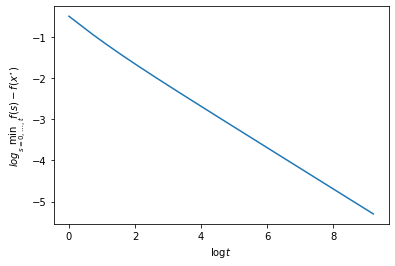

In [11]:
optimal_gaps = convergence_metrics['optimal_gap']
ts = np.arange(len(optimal_gaps)) + 1
plt.plot(np.log(ts), np.log(optimal_gaps))
plt.xlabel(r'$\log t$')
plt.ylabel(r'$log \min_{s=0, \dots, t} f(s) - f(x^{\star})$')

**Exercise 1.4.** Now we further inspect the output of `compute_convergence_metrics`. First, let us plot the ratio between the discretization error terms and the continuous-time rate terms (see equation $(3)$).

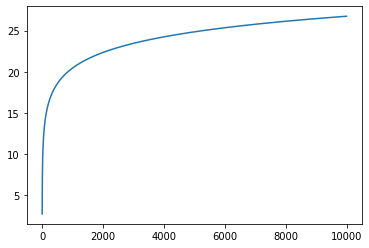

In [12]:
discretization_errors = convergence_metrics['discretization_error']
continous_time_rate = convergence_metrics['continous_time_rate']
plt.plot(ts, discretization_errors/continous_time_rate)

In the above term, we see that the discretization error is approximately $\log(t)$ (up to multiplicative constants) larger than the continuous time rate term. This ultimately gives the excess $\log t$ factor in the resulting bound proved in Exercise 1.1.

In the below cell we plot the gap between the first and second steps in equation $(3)$, i.e,
$$
  \frac{1}{\sum_{s=0}^{t} \eta_{s}}
  \sum_{s=0}^{t}\eta_{s}(f(x_{s}) - f(x^{\star}))
  -
  \min_{s=0,\dots,t} f(x_{s}) - f(x^{\star}). \tag{4}
$$
The above term was ignored by our analysis in the solution of Exercise 1.1.

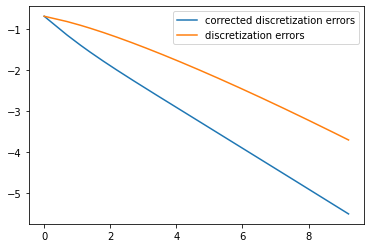

In [13]:
lost_terms = convergence_metrics['weighted_gaps'] - convergence_metrics['optimal_gap']
plt.plot(np.log(ts), np.log(discretization_errors - lost_terms))
plt.plot(np.log(ts), np.log(discretization_errors))
plt.legend(['corrected discretization errors', 'discretization errors'])

The above plot shows that a tighter analysis, which takes into account the `lost_terms` defined in $(4)$ can remove the excess $\log t$ factor, since the slope of the blue line in the above plot is equal to $-0.5$.

In the next section on the convergence analysis under smoothness assumption, taking into account the term defined in $(4)$ will be crucial to capture the correct rate of convergence.

### Minimizing $\beta$-Smooth Functions

In the previous section we have seen that minimizing a convex and Lipschitz function $f$ up to accuracy $\varepsilon$ can be done in $\Theta(1/\varepsilon^{2})$ iterations via the gradient descent method. It can be shown that this is the best one can hope for any first-order algorithm that construct estimates in the linear span of the queried sub-gradients.

We will now take a look at optimizing another class of convex functions, namely, $\beta$-smooth functions. A continuously-differentiable function $f : \mathbb{R}^{d} \to \mathbb{R}$ is called $\beta$-smooth if its gradient map is $\beta$-Lipschitz, that is, if the following holds for any $x$ and $y$ in the domain of $f$:
$$
  \|\nabla f(x) - \nabla f(y)\|_{2} \leq \beta\|x - y\|_{2}.
$$
The above definition is equivalent to the following two definitions:
$$
  \forall x,y \text{ we have } f(y) \leq f(x) + \langle \nabla f(x), y-x\rangle + \frac{\beta}{2}\|y-x\|_{2}^{2}
$$
or in the case of twice-differentiable functions:
$$
  \forall x \text{ we have } \nabla^{2} f(x) \preccurlyeq \beta I_{d},
$$
where $I_{d}$ is the $d\times d$ identity matrix and the notation $A \preccurlyeq B$ means that $B - A$ is positive semidefinite.

In the next exercise, we explore some basic properties of smooth functions that will allow us to obtain faster convergence rate than the one shown for Lipschitz functions.

#### Exercise 2

Recall that in the setting of Lipschitz functions, gradient descent with a fixed step size $\eta$ is not necessarily a *descent method*, meaning that the sequence $(f(x_{t}))_{t \geq 0}$ is not necessarily decreasing. For example, let $f(x) = |x|, \eta = 1$ and suppose that $x_{t} = 0.01$. Then, $f(x_t) = 0.01$, but $f(x_{t+1}) = 0.99$.

Now suppose that $f: \mathbb{R}^{d} \to \mathbb{R}$ is convex, differentiable, and $\beta$-smooth. Show that there exists some constant step size $\eta > 0$ (that you should specify), such that for any $x\in \mathbb{R}^{d}$ we have
$$
  f(x - \eta\nabla f(x)) \leq f(x) - \frac{1}{2\beta}\|\nabla f(x)\|_{2}^{2}.
$$
<font color='green'>**In particular, gradient descent applied to a smooth function $f$ with a properly chosen step size $\eta > 0$ is a *descent method*.**</font>




##### Solution

By the definition of $\beta$-smoothness we have
\begin{align*}
  f(x - \eta \nabla f(x))
  &\leq
  f(x) + \langle \nabla f(x), -\eta\nabla f(x)\rangle + \frac{\beta}{2}\|\eta\nabla f(x)\|_{2}^{2}\\
  &=
  f(x) + \left(-\eta + \frac{\beta\eta^{2}}{2}\right)\|\eta\nabla f(x)\|_{2}^{2}.
\end{align*}
Minimizing the above upper bound as a function of $\eta$ yields the desired result with $\eta = \frac{1}{\beta}$.


#### Plotting Optimization Paths for 2d Quadratic Functions

A canonical example of smooth and convex functions are quadratic functions of the form
$$
  f_{\Sigma, b}(x) = \frac{1}{2}x^{\mathsf{T}}\Sigma x + \langle x, b\rangle,
$$
where $\Sigma \in \mathbb{R}^{d\times d}$ and $b \in \mathbb{R}^{d}$.
Since for any $x$ we have $\nabla^{2} f_{\Sigma, b} (x) = \Sigma$, $f$ is convex if and only if $\Sigma$ is positive semidefinite, and $f$ is $\beta$-smooth if and only if the largest eigenvalue of $\Sigma$ is at most equal to $\beta$.

Below we implement a class that represents quadratic functions, parametrized by $\Sigma$ and $b$.

In [14]:
class QuadraticFunction(Function):
  """ An implementation of quadratic functions 1/2 x^t Sigma x + <x, b>. """

  def __init__(self, Sigma, b):
    """ :Sigma: An invertible d \times d matrix.
        :b: A d dimensional vector.
    """
    self.b = np.array(b).reshape(-1, 1)
    self.Sigma = np.array(Sigma)
    x_star = -np.linalg.inv(Sigma) @ b
    super().__init__(x_star)

  def __call__(self, x):
    """ Returns 1/2 x^t Sigma x + <x, b>. """
    return 0.5 * tnp.transpose(x) @ self.Sigma @ x + tnp.sum(x * self.b)

Next, we implement a class that will help visualize gradient descent trajectories when optimizing two-dimensional functions.

In [15]:
class Convergence2DPlotting(object):
  """ Plotting utils for visualizing optimization paths on 2D functions. """

  def __init__(self, f):
    self.f = f
    self.fig, self.ax = plt.subplots()
    self.fig.set_size_inches(8.0, 8.0)
    self.ax.set_aspect('equal')

    # Mark the optimal parameter x_star on plot.
    self.ax.scatter(f.x_star[0], f.x_star[1], color='red', marker='x', zorder=10)

  def plot_iterates(self, iterates, color='C0'):
    iterates = np.array(iterates).squeeze()
    x, y = iterates[:,0], iterates[:, 1]
    self.ax.scatter(x,y,s=0)
    for i in range(len(x)-1):
      self.ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                       arrowprops={'arrowstyle': '->',
                                  'color':  color, 'lw': 2})

  def plot_contours(self):
    x_min, x_max = self.ax.get_xlim()
    y_min, y_max = self.ax.get_ylim()

    # Generate the contours of f on the above computed range.
    n_points = 50
    x = np.linspace(start=x_min, stop=x_max, num=n_points)
    y = np.linspace(start=y_min, stop=y_max, num=n_points)
    x, y = np.meshgrid(x, y)
    z = np.zeros_like(x)
    for x_idx in range(n_points):
      for y_idx in range(n_points):
        input = np.array([x[x_idx, y_idx], y[x_idx, y_idx]]).reshape(2,1)
        z[x_idx, y_idx] = self.f(input)
    self.ax.contour(x,y,z, colors='k')

We now provide an example use case of the above code. Before proceeding to Exercise 3, try exploring the below code with different parameter settings to gain some intuition.

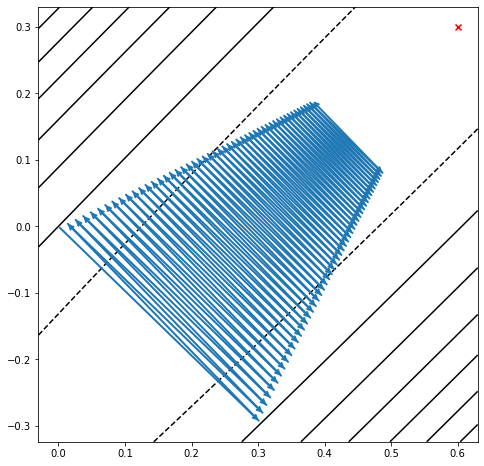

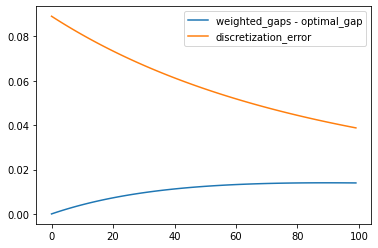

In [16]:
T = 100 # Number of iterations we will run gradient descent for.
Sigma = np.array([[1.0, -0.99], [-0.99, 1.0]]) # An example ill-conditioned function.
x_star = np.array([0.6, 0.3]).reshape(-1,1)
b = -Sigma @ x_star
eigenvalues, _ = np.linalg.eigh(Sigma)
beta = eigenvalues[-1] # The smoothness constant.
quadratic_f = QuadraticFunction(Sigma, b)
convergence_plot = Convergence2DPlotting(quadratic_f)

# Try different values of eta (e.g. 0.5/beta, 1/beta, 1.99/beta, 2.01/beta).
# Note the different behavious in the ranges
#     (0, 1/beta); 1/beta; (1/beta, 2/beta), 2/beta, (2/beta, infty).
eta = lambda t : 1.99/beta

optimizer = GradientDescent(eta = eta)
x_0 = np.array([0.0, 0.0]).reshape(2,1)
iterates = optimizer.optimize(quadratic_f, x_0, n_iterations=T)

# Generate the plot.
convergence_plot.plot_iterates(iterates)
convergence_plot.plot_contours()
convergence_metrics = compute_convergence_metrics(quadratic_f, eta, iterates)

# Now plot ('weighted_gaps' - 'optimal_gap') and 'discretization_error'.
# Revisit equation (3) and observe the plot when eta = 1/beta.
plt.show()
plt.plot(convergence_metrics['weighted_gaps'] - convergence_metrics['optimal_gap'])
plt.plot(convergence_metrics['discretization_error'])
plt.legend(['weighted_gaps - optimal_gap', 'discretization_error'])

#### Exercise 3

Let $f : \mathbb{R}^{d} \to \mathbb{R}$ be a convex and $\beta$-smooth function. Consider the sequence of gradient descent iterates generated with a fixed step size $\eta = \frac{1}{\beta}$:
\begin{align*}
  x_{t+1} = x_{t} - \frac{1}{\beta} f(x_{t}).
\end{align*}
Prove that for any $T \geq 1$ we have
$$
  f(x_{T}) - f(x^{\star}) \leq \frac{\beta\|x^{\star} - x_{0}\|_{2}^{2}}{2T}.
$$

##### Solution

Recall the potential-based proof technique introduced in the section on L-Lipschitz functions. Rewriting equation $(3)$ for fixed step size $\eta$ we have
$$
  \frac{1}{T+1}\sum_{t=0}^{T}(f(x_{t}) - f(x^{\star}))
  \leq
  \underbrace{\frac{\|x^{\star} - x_{0}\|_{2}^{2}}{2\eta (T+1)}}_{
   \text{continuous-time rate} 
  }
  +
  \underbrace{\frac{\sum_{t=0}^{T}\eta \|\nabla f(x_{t})\|_{2}^{2}}
         {2}}_{\text{discretization error}}.
$$
From exercise 2 we know that with step size $\eta = \frac{1}{\beta}$ the function values $(f(x_{t}))_{t \geq 0}$ are decreasing and so the optimal function value $f(x_{t})$ is attained by the last iterate $x_{T}$. We thus have
\begin{align*}
  f(x_{T}) - f(x^{\star})
  &= \frac{1}{T} \sum_{t=0}^{T-1} (f(x_{T}) - f(x_{t}) + f(x_{t}) - f(x^{\star}))
  \\
  &= \underbrace{\frac{1}{T} \sum_{t=0}^{T-1} (f(x_{T}) - f(x_{t}))}_{
   \text{"optimal gap" - "weighted gap"} 
  }
     + \frac{1}{T} \sum_{t=0}^{T-1}(f(x_{t}) - f(x^{\star}))
  \\
  &\leq \underbrace{\frac{1}{T} \sum_{t=0}^{T-1} (f(x_{T}) - f(x_{t}))}_{
   \text{"optimal gap" - "weighted gap"} 
  }
  +
  \underbrace{\frac{\|x^{\star} - x_{0}\|_{2}^{2}}{2\eta T}}_{
   \text{continuous-time rate} 
  }
  +
  \underbrace{\frac{\sum_{t=0}^{T-1}\eta \|\nabla f(x_{t})\|_{2}^{2}}
         {2}}_{\text{discretization error}}.
  \\
\end{align*}
In the simulations performed previously (in the cell preceding this exercise), we should have observed that when $\eta = \frac{1}{\beta}$, the
"optimal gap" - "weighted gap" term should be negative enough to approximately compensate for the "discretization error" term. <font color='green'>**In particular, this means that the guaranteed gains in the decrease of the objective $f(x_{t}) - f(x_{t+1})$ are enough to compensate for the discretization error. This should be contrasted with the Lipschitz case, where we did not have a guaranteed decrease in objective value at each time step, and the only way to extinguish the discretization error was by considering small step sizes, which in turn resulted in slow convergence.**</font> To simplify the notation, let
$$
  \delta_{t} = f(x_{t+1}) - f(x_{t}) \leq -\frac{1}{2\beta}\|\nabla f(x_{t})\|_{2}^{2},
$$
where the above inequality follows from Exercise 2 with our choice of step size $\eta = \frac{1}{\beta}$. We can now proceed as follows:
\begin{align*}
  &\underbrace{\frac{1}{T} \sum_{t=0}^{T-1} (f(x_{T}) - f(x_{t}))}_{
   \text{"optimal gap" - "weighted gap"} 
  }
  +
  \underbrace{\frac{\sum_{t=0}^{T-1}\eta \|\nabla f(x_{t})\|_{2}^{2}}
         {2}}_{\text{discretization error}}
  \\
  &= \frac{1}{T} \sum_{t=0}^{T-1} (\delta_{T-1} + \delta_{T-2} + \dots + \delta_{t})
  +
  \frac{\sum_{t=0}^{T-1}\eta \|\nabla f(x_{t})\|_{2}^{2}}
         {2}
  \\
  &= \sum_{t=0}^{T-1} \left( (t+1)\delta_{t} 
  + \frac{\eta}{2} \|\nabla f(x_{t})\|_{2}^{2}
  \right) 
  \\
  &\leq
  \sum_{t=0}^{T-1} \left( -(t+1)\frac{1}{2\beta}\|\nabla f(x_{t})\|_{2}^{2}
  + \frac{\eta}{2} \|\nabla f(x_{t})\|_{2}^{2}
  \right) 
  & \text{by Exercise 2}
  \tag{5}
  \\
  &\leq
  \sum_{t=0}^{T-1} -t\frac{1}{2\beta}\|\nabla f(x_{t})\|_{2}^{2}
  & \text{since }\eta = \frac{1}{\beta}
  \\
  &\leq 0.
\end{align*}

Putting everything together yields the desired result
$$
  f(x_{T}) - f(x_{\star}) \leq 
  \frac{\beta \|x^{\star} - x_{0}\|_{2}^{2}}{2T}.
$$

### Nesterov's Acceleration for $\beta$-Smooth Functions

In exercise 3, we have shown that gradient descent achieves $O(1/t)$ convergence rate for smooth and convex functions. However, the optimal rate for the class of smooth and convex functions is $O(1/t^{2})$, achieved by the celebrated Nesterov's accelerated gradient descent. We will now present the algorithm, but first we provide some intuition. See the bibliographic remarks section for the references on which our presentation is based, which contain extensions to non-Euclidean settings and further discussions.

To gain some insight into Nesterov's accelerated algorithm, it is worth revisiting the convergence proof for smooth functions, particularly equation $(5)$ where we wanted to show that the following term is at most equal to $0$:
$$
  \sum_{t=0}^{T-1} \left( \underbrace{-(t+1)\frac{1}{2\beta}\|\nabla f(x_{t})\|_{2}^{2}}_{
   \text{a term arising from guaranteed decrease in objective value} 
  }
  + 
  \underbrace{
    \frac{\eta}{2} \|\nabla f(x_{t})\|_{2}^{2}}_{
    \text{discretization error arising from the step}f(x_{t+1}) = f(x_{t}) - \eta\nabla f(x_{t})
  }
  \right).
$$
In our analysis, we have used $\eta = \frac{1}{\beta}$ to arrive at the above equation. The issue is, however, that with such choice of step size we ignore the negative terms $-t\|\nabla f(x_{t})\|_{2}^{2}$ in our rate of convergence bound. In order to make the above term equal to zero, we would ideally consider a varying step sizes scheme $\eta_{t} = \frac{t+1}{\beta}$, which would result in the "continuous-time rate" term decaying at the optimal rate $O(1/t^2)$.

The above discussion motivates the following approach: consider one process with aggressive step sizes $\eta_{t} = \frac{t+1}{2\beta}$ (two times smaller than informally suggested above), <font color='green'>**which will intuitively help decrease the "continuous-time rate" term at a quadratic rate $O(1/t^{2})$.**</font> At the same time, consider another, more conservative process with a fixed step size $\eta = \frac{1}{\beta}$. <font color='green'>**The guaranteed decrease in the objective value of this more conservative process will hopefully be enough to extinguish large discretization errors arising from the aggressive process.**</font> Finally, we linearly couple the two processes together to yield the following algorithm:

---

  **Accelerated Gradient Descent**
  
  \begin{align*}
    &x_{0} = y_{0} = z_{0} = 0 \\
    &x_{t+1} = z_{t} - \frac{1}{\beta}\nabla f(z_{t}) & \text{the conservative process}\\
    &y_{t+1} = y_{t} - \frac{t+1}{2\beta}\nabla f(z_{t}) & \text{the aggressive process} \\
    &z_{t+1} = (1-\tau_{t+1})x_{t+1} + \tau_{t+1} y_{t+1} & \text{the coupled process},
  \end{align*}
  where $(\tau_{t})_{t\geq 1}$ is a sequence of coupling weights that you will be asked to work out in Exercise 4.

---

As discussed, the discretization error should arise from the aggressive process. Thus, we start by mimicking the potential-based proof strategy that worked for Lipschitz and smooth functions, by first inspecting the change in the potential $\|x^{\star} - y_{t}\|_{2}^{2}$ for the iterates $(y_{t})_{t\geq 0}$:
$$
  \|x^{\star} - y_{t}\|_{2}^{2} - \|x^{\star} - y_{t+1}\|_{2}^{2}
  = \frac{t+1}{\beta}\left\langle -\nabla f(z_{t}), x^{\star} - y_{t} \right\rangle
  - \underbrace{\frac{(t+1)^{2}}{4\beta^{2}}\|\nabla f(z_{t})\|_{2}^{2}}_{\text{discretization error term}}.
  \tag{6}
$$
We now want to manipulate the inner product term into quantities that will lead to "guaranteed decrease in the objective value", via the fact that the conservative process satisfies $f(x_{t+1}) \leq f(z_{t}) - \frac{1}{2\beta}\|\nabla f(z_{t})\|_{2}^{2}$ (cf. Exercise 2). We proceed as follows, by plugging in the definition of $z_{t}$:
\begin{align*}
   &\frac{t+1}{\beta}
   \left\langle -\nabla f(z_{t}), x^{\star} - y_{t} \right\rangle
   \\
   &=
   \frac{t+1}{\beta}
   \left\langle -\nabla f(z_{t}), x^{\star} - \left(z_{t} + (1 - 1/\tau_{t})(x_{t} - z_{t})\right) \right\rangle
   \\
   &=
   \frac{t+1}{\beta}
   \underbrace{\left\langle -\nabla f(z_{t}), x^{\star} - z_{t}
   \right\rangle}_{\geq f(z_{t}) - f(x^{\star})}
   +\frac{t+1}{\beta}\frac{1 - \tau_{t}}{\tau_{t}}\underbrace{\left\langle -\nabla f(z_{t}), x_{t} - z_{t} \right\rangle}_{\geq f(z_{t}) - f(x_{t})}
   \\
   &\geq
   \frac{t+1}{\beta}(f(z_{t}) - f(x^{\star}))
   + \frac{t+1}{\beta}\frac{1 - \tau_{t}}{\tau_{t}}(f(z_{t}) - f(x_{t}))
   & \text{assuming }\tau_{t} \in [0,1]
   \\
   &\geq
   \frac{t+1}{\beta}\left(
     f(x_{t+1}) + \frac{1}{2\beta}\|\nabla f(z_{t})\|_{2}^{2} - f(x^{\star})
  \right)
   + \frac{t+1}{\beta}\frac{1 - \tau_{t}}{\tau_{t}}
   \left(
     f(x_{t+1}) + \frac{1}{2\beta}\|\nabla f(z_{t})\|_{2}^{2} - f(x_{t})
   \right)
   & \text{since }f(z_{t}) \geq f(x_{t+1}) + \frac{1}{2\beta}\|\nabla f(z_{t})\|_{2}^{2}
   \\
   &=
   \frac{t+1}{\beta}\left(
     f(x_{t+1})  - f(x^{\star})
  \right)
   + \frac{t+1}{\beta}\frac{1 - \tau_{t}}{\tau_{t}}
   \left(
     f(x_{t+1}) - f(x_{t})
   \right)
   + \frac{t+1}{2\beta^{2}}\frac{1}{\tau_{t}}\|\nabla f(z_{t})\|_{2}^{2}.
\end{align*}
Plugging the above into $(6)$ yields the following expression for the change of potential
\begin{align*}
  \|x^{\star} - y_{t}\|_{2}^{2} - \|x^{\star} - y_{t+1}\|_{2}^{2}
  =
   \frac{t+1}{\beta}\left(
     f(x_{t+1})  - f(x^{\star})
  \right)
   + \frac{t+1}{\beta}\frac{1 - \tau_{t}}{\tau_{t}}
   \left(
     f(x_{t+1}) - f(x_{t})
   \right)
   +
   \frac{t+1}{2\beta^{2}}
   \left(
     \frac{1}{\tau_{t}} - \frac{t+1}{2}
  \right)\|\nabla f(z_{t})\|_{2}^{2} \tag{7}.
\end{align*}

#### Exercise 4

Let $f : \mathbb{R}^{d} \to \mathbb{R}$ denote a convex and $\beta$-smooth function.

- Using equation (7), adapt the convergence proof for smooth functions presented in Exercise 3 to Nesterov's accelerated gradient descent for some choice of coupling weights $\tau_{t} \in [0,1]$ that you should specify. Prove that
$$
  f(x_{T}) - f(x^{\star}) \leq \frac{2\beta \|x^{\star} - y_{0}\|_{2}^{2}}{T(T+1)}.
$$
- Implement the Nesterov's accelerated gradient descent algorithm described above, with the coupling weights sequence that you worked out in the previous part of this exercise.
- Visualize optimization paths of gradient descent with and without acceleration on an ill-conditioned two-dimensional quadratic objective.

##### Solution

To simplify the notation, let
$$
  \delta_{t} = f(x_{t+1}) - f(x_{t}).
$$
Set $\tau_{t} = \frac{2}{t+2}$ and note that this choice makes the right most term in $(7)$ non-negative. Thus, the change of potential specified in $(7)$ can be lower bounded as follows:
\begin{align*}
  \|x^{\star} - y_{t}\|_{2}^{2} - \|x^{\star} - y_{t+1}\|_{2}^{2}
  &\geq 
   \frac{t+1}{\beta}\left(
     f(x_{t+1})  - f(x^{\star})
  \right)
   + \frac{t+1}{\beta}\frac{1 - \frac{2}{t+2}}{\frac{2}{t+2}}
   \left(
     f(x_{t+1}) - f(x_{t})
   \right)
  \\
  &=
   \frac{t+1}{\beta}\left(
     f(x_{t+1})  - f(x^{\star})
  \right)
   + \frac{(t+1)t}{2\beta} \delta_{t}.
\end{align*}
Summing the above for $t=0,1,\dots,T-1$ yields
\begin{align*}
  \|x^{\star} - y_{0}\|_{2}^{2}
  &\geq \sum_{t=0}^{T-1}\frac{t+1}{\beta}(f(x_{t+1}) - f(x^{\star}))
  + \sum_{t=0}^{T-1}\frac{(t+1)t}{2\beta}\delta_{t}
  \\
  &= \sum_{t=1}^{T}\frac{t}{\beta}(f(x_{t}) - f(x^{\star}))
  + \sum_{t=0}^{T-1}\frac{(t+1)t}{2\beta}\delta_{t}. \tag{8}
\end{align*}
Now notice that for any $t \in {1, \dots, T-1}$ we have
$$
  f(x_{t}) - f(x^{\star})
  = f(x_{T}) - f(x^{\star}) - (f(x_{T}) - f(x_{t}))
  = f(x_{T}) - f(x^{\star}) - (\delta_{t} + \delta_{t+1} + \dots + \delta_{T-1}).
$$
Plugging the above into $(8)$ yields
\begin{align*}
  \|x^{\star} - y_{0}\|_{2}^{2}
  &\geq \sum_{t=1}^{T} \frac{t}{\beta}(f(x_{T}) - f(x^{\star}) - (\delta_{t} + \dots + \delta_{T-1}))
  + \sum_{t=0}^{T-1} \frac{(t+1)t}{2\beta}\delta_{t}
  \\
  &=
  \frac{T(T+1)}{2\beta}(f(x_{T}) - f(x^{\star}))
  - \sum_{t=1}^{T-1}\frac{t(t+1)}{2\beta}\delta_{t}
  + \sum_{t=0}^{T-1} \frac{(t+1)t}{2\beta}\delta_{t}
  \\
  &=
  \frac{T(T+1)}{2\beta}(f(x_{T}) - f(x^{\star})).
\end{align*}
Dividing both sides by $\frac{T(T+1)}{2\beta}$ yields the desired result.

We are now ready to implement Nesterov's accelerated gradient decent.

In [17]:
# To implement the accelerated gradient descent algorithm we will override the
# `step` method of the base class `Optimizer`.
class AcceleratedGradientDescent(Optimizer):
  """ An implementation of gradient descent uptades.
  
      A new instance of this class should be created for each function that we
      want to optimize, as this optimizer will hold internal variables (the
      iterates y_t and z_t) that are specific to the function that is currently
      being minimized.
  """

  def __init__(self, beta):
    """ :beta: Smoothness parameter of the function that we want to optimize. """
    self.beta = beta
    super().__init__(eta=None)

  def step(self, f, x_t):
    if not hasattr(self, 'z_t'):
      # This is the first iteration. Initialize z_0 = y_0 = x_0 = x_t.
      self.y_t = tf.Variable(x_t)
      self.z_t = tf.Variable(x_t)

    with tf.GradientTape() as tape:
      fx = f(self.z_t)
    g_t = tape.gradient(fx, self.z_t)

    # Perform the aggressive update.
    aggresive_eta = (self.t+1) * 0.5 / self.beta
    self.y_t.assign_add(-aggresive_eta * g_t)
    # Perform the conservative update.
    conservative_eta = 1.0/self.beta
    x_t.assign(self.z_t-conservative_eta*g_t)
    # Couple the two processes together.
    tau = 2.0/(self.t+2.0)
    self.z_t.assign((1.0-tau)*x_t + tau*self.y_t)

    # Update the iterations counter.
    self.t += 1


We can visualize optimization paths by reusing the code written in the cell preceding Exercise 3.

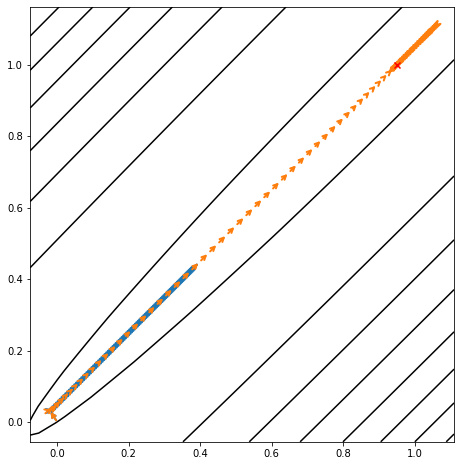

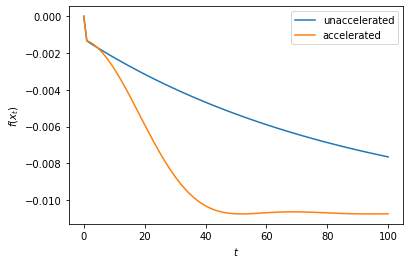

In [18]:
T = 100 # Number of iterations we will run gradient descent for.
Sigma = np.array([[1.0, -0.99], [-0.99, 1.0]]) # An example ill-conditioned function.
x_star = np.array([0.95,1.0]).reshape(-1,1)
b = -Sigma @ x_star
eigenvalues, _ = np.linalg.eigh(Sigma)
beta = eigenvalues[-1] # The smoothness constant.
quadratic_f = QuadraticFunction(Sigma, b)
convergence_plot = Convergence2DPlotting(quadratic_f)

perturbed_beta = 0.9*beta # the value of beta supplied to the optimizer.
eta = lambda t : 1.0/perturbed_beta
unaccelerated_optimizer = GradientDescent(eta = eta)
accelerated_optimizer = AcceleratedGradientDescent(perturbed_beta)

x_0 = np.array([0.0, 0.0]).reshape(2,1)
unaccelerated_iterates = unaccelerated_optimizer.optimize(
    quadratic_f, x_0, n_iterations=T)
accelerated_iterates = accelerated_optimizer.optimize(
    quadratic_f, x_0, n_iterations=T)

# Generate the plot.
convergence_plot.plot_iterates(unaccelerated_iterates, color='C0')
convergence_plot.plot_iterates(accelerated_iterates, color='C1')
convergence_plot.plot_contours()

# Compute and plot values of f(x_t) for both runs.
f_xt_unaccelerated = np.zeros(len(unaccelerated_iterates))
f_xt_accelerated = np.zeros(len(accelerated_iterates))
for t in range(len(f_xt_unaccelerated)):
  f_xt_unaccelerated[t] = quadratic_f(unaccelerated_iterates[t])
  f_xt_accelerated[t] = quadratic_f(accelerated_iterates[t])

plt.show()
plt.plot(f_xt_unaccelerated)
plt.plot(f_xt_accelerated)
plt.xlabel(r'$t$')
plt.ylabel(r'$f(x_{t})$')
plt.legend(['unaccelerated', 'accelerated'])

## Projected Mirror Desent

Let $\mathcal{D} \subseteq \mathbb{R}^{d}$ be convex and open set and let $\Phi : \mathcal{D} \to \mathbb{R}$ be a *mirror map* - a strictly convex and differentiable function whose gradient $\nabla \Phi : \mathcal{D} \to \mathbb{R}^{d}$ is subjective and diverges on the boundary of $\mathcal{D}$. Let
  $$D^{\Phi}(x, y) = \Phi(x) - \Phi(y) - \langle \nabla \Phi(y), x-y \rangle$$
denote the
*Bregman divergence*, and for a convex set $\mathcal{C} \subseteq \mathcal{D}$, let the *Bregman projection* be denoted by
$$
  \Pi_{\mathcal{C}}^{\Phi}(y) = \mathrm{argmin}_{x \in \mathcal{C}} D^{\Phi}(x, y).
$$
Recall that the *projected mirror descent* algorithm for optimizing a convex function $f$ over the constraint set $\mathcal{C}$ is given by the following updates:
\begin{align*}
  \tilde{x}_{t+1}
  &= (\nabla \Phi)^{-1}\left(\nabla \Phi(x_{t}) - \eta_{t} f(x_{t})\right),
  \\
  x_{t+1}
  &= \Pi_{\mathcal{C}}^{\Phi}(\tilde{x}_{t+1}).
\end{align*}
Notice that mirror descent is a strict generalization of gradient descent: the choice $\Phi(x) = \frac{1}{2}\|x\|_{2}^{2}$ reduces mirror descent updates to gradient descent updates, and the Bregman projection $\Pi_{\mathcal{C}}^{\Phi}$ becomes the usual Euclidean projection minimizing the $\ell_{2}$ norm.

We will now consider a simple example motivating the need of the generalization offered by the family of mirror descent algorithms. Let $\mathcal{C} = \Delta_{d} = \{ x \in [0,1]^{d} : \sum_{i=1}^{d} x_{i} = 1\}$ denote the $d$-dimensional simplex. Let $f_{d} : \Delta_{d} \to \mathbb{R}$ denote
a function
$$
  f_{d}(x) = \|x-e_{1} - \xi\|_{1},
$$
where $e_{1}$ is the first basis vector $(1, 0, \dots, 0)^{\mathsf{T}} \in \mathbb{R}^{d}$ and $\xi \sim N(0, d^{-2}I_{d})$ is a noise variable. Then, for a typical vector $x \in \Delta_{d}$ we have $\|\nabla f_{d}(x)\|_{2} = \sqrt{d}$, that is, the Lipschitz constant of $f$ deteriorates with the dimension $d$, which may in turn result in slow convergence rates for the projected sub-gradient method. Let us try to verify if this is indeed the case.

In [19]:
class L1NormFunction(Function):
  """ An implementation of the function f_{d, A} described above. """

  def __init__(self, d):
    # x_star is equal to the first basis vector e1.
    x_star = np.zeros(d).reshape(d, 1)
    x_star[0,0] = 1.0
    # Add some noise to "confuse" the projected gradient method.
    np.random.seed(0)
    xi = np.random.normal(0, 1, size=(d,1)) / d
    x_star += xi
    super().__init__(x_star)

  def __call__(self, x):
    """ Computes ||x - x_star||_{1}. """
    return tnp.sum(tnp.abs(x - self.x_star))

We will now implement the project subgradient method with Euclidean projections onto the simplex.

In [20]:
class ProjectedGradientDescent(GradientDescent):
  """ An implementation of projected gradient descent, with Euclidean
  projections onto the unit simplex. """

  def apply_gradient(self, x_t, g_t):
    super().apply_gradient(x_t, g_t) # Perform the gradient update.
    self.project_onto_simplex(x_t)

  def project_onto_simplex(self, x_t):
    y = x_t.numpy()
    # To perform projection onto the simplex, we need to find a real number
    # a such that \sum_{i=1}^{d} max{0, y_{i} - a} = 1. The projected vector is then
    # equal to max{0, y-a}, where max is taken component-wise.

    # We will use binary search to approximate a.
    def sum_of_shifted_vector_coordinates(a):
      """ :a: Given a, return \sum_{i=1}^{d} max{y_{i} - a, 0}. """
      shifted_vector = y - a
      shifted_vector[shifted_vector < 0.0] = 0.0
      return np.sum(shifted_vector)

    a_max = 0
    delta = 1.0
    while sum_of_shifted_vector_coordinates(a_max) > 1.0:
      a_max += delta
      delta *= 2.0

    a_min = 0
    delta = 1.0
    while sum_of_shifted_vector_coordinates(a_min) < 1.0:
      a_min -= delta
      delta *= 2.0

    while a_max - a_min > 1e-6:
      midpoint = (a_max + a_min) / 2.0
      if sum_of_shifted_vector_coordinates(midpoint) > 1.0:
        a_min = midpoint
      else:
        a_max = midpoint

    projected_x = y - (a_max + a_min) / 2.0
    projected_x[projected_x < 0.0] = 0.0
    x_t.assign(projected_x) 

In order to test the performance of a given optimization method, we implement the following function, which runs the given optimizer on the above described $\ell_{1}$ minimization problem for different choices of the dimension $d$.
Notice that $f_{d}(e_{1}) = \sum_{i=1}^{d}|\xi_{i}|$, where $\xi \sim N(0, d^{-2}I_{d})$. Thus $f_{d}(e_{1}) \approx \sqrt{\frac{2}{\pi}}\approx 0.8 < 0.9$.
In addition to plotting the values of $f(x_{t})$ against the number of iterations $t$, we will also compute how many iterations are needed to reach an iterate $x_{t} \in \Delta_{d}$ such that $f(x_{t}) \leq 0.9$.

In [21]:
def test_optimizer_for_minimization_over_simplex(optimizer_factory):
  """ This function tests how the supplied optimizer's performance scales with
  the dimension d, for the l1 minimization problem described above.
  
      :optimizer_factor: A function, taking as argument the dimension d and
        returning the optimizer to be used for optimizing f.
  """
  
  ds = np.array([100, 200, 400, 800, 1600])
  first_iterate_to_hit_target = np.zeros_like(ds)

  for d_idx, d in enumerate(ds):
    f = L1NormFunction(d)
    x_0 = tf.Variable(np.ones((d,1))/d)
    optimizer = optimizer_factory(d)
    iterates = optimizer.optimize(f, x_0, 500)
  
    fx = np.zeros(len(iterates))
    for idx, iterate in enumerate(iterates):
      fx[idx] = f(iterate)
    plt.plot(fx)

    # Save the number of iterations to first reach f(x_t) <= 0.9.
    first_iterate_to_hit_target[d_idx] = np.argmin(fx > 0.9)

  plt.xlabel(r'$t$')
  plt.ylabel(r'$f(x_t)$')
  plt.title("Minimization over a simplex for different dimensions")
  plt.legend(ds)

  plt.show()
  plt.plot(ds.astype('str'), first_iterate_to_hit_target, marker='s')
  plt.xlabel(r'$d$')
  plt.ylabel(r'of first $t$ such that $f(x_{t}) \leq 0.9$')
  plt.title("Iteration complexity vs dimension")

We can now test the projected subgradient method with the following code.

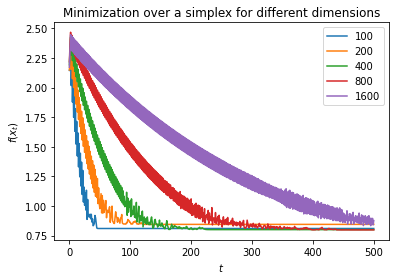

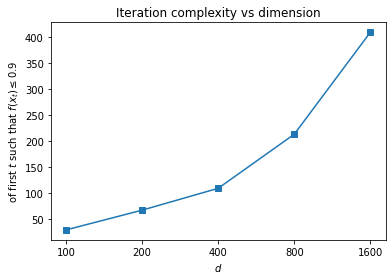

In [22]:
def projected_gradient_descent_factory(d):
  # You may experiment with different step-size schemes
  # (e.g., dimension-dependent schemes).
  eta = lambda t : np.sqrt(0.1/(t+1))
  return ProjectedGradientDescent(eta)

test_optimizer_for_minimization_over_simplex(projected_gradient_descent_factory)

<font color='green'>**Observe that the performance of projected sub-gradient method deteriorates significantly with the dimension $d$. As discussed above, the reason for this is that the Lipschitz constant of $f_{d}$ scales as $\sqrt{d}$.**</font>

Observe, however, that we always have $\|\nabla f_{d}(x)\|_{\infty} \leq 1$; in other words, for any dimension $d$ the function $f_{d}$ is $1$-Lipschitz with respect to $\ell_{1}$ norm (the dual norm of $\ell_{\infty}$ norm). Thus, the projected mirror descent with a mirror map $\Psi$ that is strongly convex on $\Delta_{d}$ with respect to the $\ell_{1}$ norm should yield an (almost) dimension-independent convergence rate. This is the subject of the next exercise.

### Exercise 5

With a proper choice of the mirror map $\Phi$, implement projected mirror descent method described at the beginning of this section, with projections onto the simplex $\Delta_{d}$. Test your implementation by calling the function `test_optimizer_for_minimization_over_simplex`. How does the performance of your method compare with performance of the projected sub-gradient descent investigated above?

#### Solution

<font color='green'>**By [Pinsker's inequality](https://en.wikipedia.org/wiki/Pinsker%27s_inequality), the negative entropy mirror map $\Phi(x) = \sum_{i=1}^{d} x_{i}\log x_{i}$ is $1$-strongly convex with respect to the $\ell_{1}$ norm when constrained to the simplex $\Delta_{d}$.**</font> We then have $\nabla \Phi(x) = \log(x) + 1$ and the mirror descent updates become
$$
  \log(\tilde{x}_{t+1}) = \log(x_{t}) - \eta_{t}\nabla f(x_{t})
$$
which yields
$$
  \tilde{x}_{t+1} = x_{t}\exp\left(- \eta_{t}\nabla f(x_{t})\right),
$$
where the multiplication, $\exp$ and $\log$ operations are performed component-wise.
Finally, the projection onto the simplex with respect to the negative entropy potential amounts to a simple renormalization step:
$$
  x_{t+1} = \Pi^{\Phi}_{\Delta_{d}} (\tilde{x}_{t+1})
  = \frac{\tilde{x}_{t+1}}{\sum_{i=1}^{d} (\tilde{x}_{t+1})_{i}}.
$$
We implement the above updates in the next cell.

In [23]:
class ProjectedMirrorDescent(Optimizer):
  """ An implementation of projected mirror descent with negative entropy mirror
  map and projections onto the simplex. """

  def apply_gradient(self, x_t, g_t):
    eta = self.eta(self.t) 
    tilde_x = x_t.numpy() * np.exp(- eta * g_t.numpy())
    projected_x = tilde_x / np.sum(tilde_x)
    x_t.assign(projected_x)

We can now test its performance on the $\ell_{1}$ minimization problem

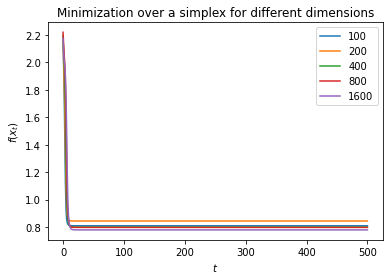

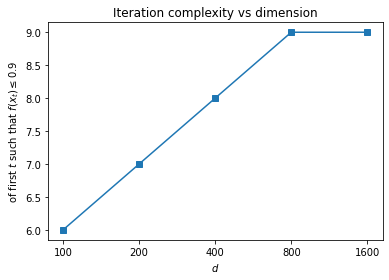

In [24]:
def projected_mirror_descent_factory(d):
  eta = lambda t : np.sqrt(1.0/(t+1))
  return ProjectedMirrorDescent(eta)

test_optimizer_for_minimization_over_simplex(projected_mirror_descent_factory)

We observe that projected mirror descent finds the optimal solution in just a few iterations, in strong contrast to the simulations observed for the projected subgradient descent.

## Stochastic Gradient Descent

We conclude this practical session by taking a brief look at stochastic gradient update, a topic of particular interest in large scale machine learning applications, where stochastic updates can yield big computational savings in comparison to the deterministic updates. We will consider a setting where the function $f : \mathbb{R}^{d} \to \mathbb{R}$ is $\beta$-smooth and $\alpha$-strongly convex, and in addition, it decomposes as a sum of $n$ $\beta$-smooth functions:
$$
  f(x) = \frac{1}{n}\sum_{i=1}^{n}f_{i}(x).
$$
In machine learning applications, $f_{i}(x)$ is a (possibly regularized) loss on the $i$-th data point. The $\alpha$-strong convexity of $f$ (which amounts to requiring that $f(x) - \frac{\alpha}{2}\|x\|_{2}^{2}$ is convex) typically comes from an added regularization penalty term. As an illustrative example we will consider the $\ell_{2}$-regularized linear regression, given by the empirical loss
$$
  f(x) = \frac{1}{n} \sum_{i=1}^{n} (\langle x, a_{i}\rangle - b_{i})^{2} + \frac{\alpha}{2}\|x\|_{2}^{2},
$$
thus $f_{i}(x) = (\langle x, a_{i} \rangle - b_{i})^{2}$. Let us now implement this function below.


In [25]:
def generate_dataset(n, d):
  """ A function that generates a linear regression dataset using the bounded
  spiked covariance model described above.

    :returns: (A, b), where A is an n \times d numpy array, whose i-th row is
      equal to the i-th covariate vector a_i and b an n \times 1 numpy array
      whose i-th row equals <a_i, w*> + N(0,1), where w* is some gruond truth
      parameter.
  """
  np.random.seed(0)
  # First generate the covariates matrix.
  A1 = np.random.normal(0, 1, size=(n,d)) # Identity covariance component.
  A2 = np.ones((n, d)) * np.random.normal(0,1,size=(n,1)) # Spiked component.
  A = A1 + A2
  A /= np.sqrt(np.sum(A**2, axis=1)).reshape(-1,1) # Normalize rows of A.
  # Sample some ground truth parameter w*.
  w_star = np.random.normal(0, 1, size=(d,1))
  # Normalize the ground truth parameter to have norm 5 (for 2d plots).
  w_star /= np.sqrt(np.sum(w_star**2)) / 5.0
  # Generate the observations.
  b = A @ w_star + np.random.normal(0, 1, size=(n,1))
  print(b.shape)
  return A, b

class RegularizedLeastSquaresLoss(Function):
  """ An implementation of the regularized least squares loss function.
  
      The dataset is sampled using the above defined `generate_dataset`
      function.

      The implemented regularized empirical risk is equal to:
        f(x) = \frac{1}{n}||Ax - b||_{2}^{2} + \frac{\alpha}{2}||x||_{2}^{2}.
  """

  def __init__(self, n, d, alpha):
    """ :n: Number of data points.
        :d: Dimension of the covariates.
        :alpha: A parameter specifying the strong convexity constant.
    """
    A, b = generate_dataset(n, d)
    # Find the empirical risk minimizer x_star.
    Sigma_alpha = np.transpose(A) @ A  + np.identity(d) * n * alpha / 2.0
    x_star = np.linalg.inv(Sigma_alpha) @ (np.transpose(A) @ b)
    self.A = A
    self.b = b
    self.alpha = alpha
    # Introduce a flag which determines wheter we represent a deterministic
    # version of this function, or a stochastic version (see the comment in
    # the definition of __call__(self, x)).
    self.stochastic_setting = False
    super().__init__(x_star) 

  def __call__(self, x):
    """ Returns f(x) = ||Ax - b||_2^2 / n + alpha/2 * ||x||_2^2.

    If the class member `stochastic_setting` is set to true, then this function
    returns f_i(x) =  (<a_i, x> - b_i)^2 + alpha/2 * ||x||_2^2 for a uniformly
    sampled index i \in {0, \dots, n-1}.
    """
    if self.stochastic_setting is False:
      # Return the deterministic gradient.
      return tnp.average((self.A @ x - self.b)**2) \
             + self.alpha/2.0 * tnp.sum(x**2)
    # We are in a stochastic setting, evaluate this function on a randomly
    # chosen data point.
    n = self.A.shape[0]
    self.I = np.random.choice(n)
    return self.evaluate_f_i(x, self.I)

  def evaluate_f_i(self, x, i):
    """ Returns f_i(x) =  (<a_i, x> - b_i)^2 + alpha/2 * ||x||_2^2. """
    return (tnp.sum(self.A[i,:].reshape(-1,1) * x) - self.b[i,0])**2 \
           + self.alpha/2.0 * tnp.sum(x**2)


(100, 1)
The deterministic function is 1.2650520245054953 smooth


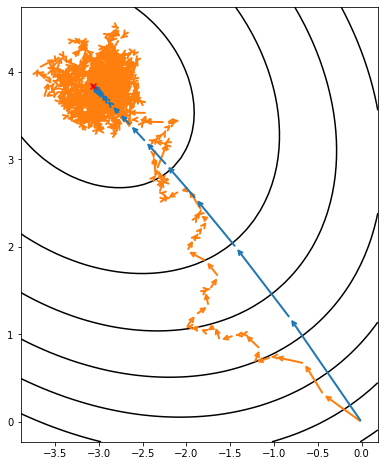

In [26]:
n = 100
f = RegularizedLeastSquaresLoss(n=n, d=2, alpha=0.0)
convergence_plot = Convergence2DPlotting(f)

sample_covariance_eigenvalues, _ = np.linalg.eigh(np.transpose(f.A) @ f.A / n)
beta = 2.0 * sample_covariance_eigenvalues[-1] + f.alpha/2.0
print("The deterministic function is", beta, "smooth")
eta = lambda t : 0.5/beta

optimizer = GradientDescent(eta = eta)
x_0 = np.array([0.0, 0.0]).reshape(2,1)
iterates = optimizer.optimize(f, x_0, n_iterations=100)

# Now run SGD.
eta = lambda t : 0.05
optimizer = GradientDescent(eta = eta)
f.stochastic_setting = True
stochastic_iterates = optimizer.optimize(f, x_0, n_iterations=1000)

# Generate the plot.
convergence_plot.plot_iterates(stochastic_iterates, color='C1')
convergence_plot.plot_iterates(iterates, color='C0')
f.stochastic_setting = False
convergence_plot.plot_contours()

<font color='green'>**We see that stochastic gradient descent iterates do not converge to the minimizer; instead, they form a cloud around the minimizer and keep bouncing around indefinitely. This happens because the of the variance in the gradients, which is non-zero even at the optimal point $x^{\star}$.**</font> Among possible approaches to reduce this variance is averaging the iterates or considering decreasing step size schemes. In the next section we present the main idea behind the more modern approach to variance reduction based on centering of the gradients.

### Variance Reduction

To see how variance of the gradients enters the convergence bounds, it is instructive to revisit the potential-based proof strategy that we previously employed in the deterministic case. Recall that this time the iterates $X_{0}, X_{1}, \dots, X_{T}$ are random variables that follow the following updates
$$
  X_{t+1} = X_{t} - \eta_{t} G_{t} \quad\text{where}\quad
  \mathbf{E}[G_{t} \vert X_{t}] \in \partial f(X_{t}),
$$
where the condition  $\mathbf{E}[G_{t} \vert X_{t}] \in \partial f(X_{t})$ means that the random update directions $G_{t}$, conditionally on the current iterate $X_{t}$, are on average sub-gradients at the point $X_{t}$. We will simply assume that $f$ is differentiable and $\mathbf{E}[G_{t} \vert X_{t}] = \nabla f(X_{t})$. Hence, we have
\begin{align*}
  \|X_{t} - x^{\star}\|_{2}^{2} - \|X_{t+1} - x^{\star}\|_{2}^{2}
  &= 2\eta_{t}\left\langle G_{t}, x^{\star} - X_{t} \right\rangle
  - \eta_{t}^{2}\|G_{t}\|_{2}^{2}
\end{align*}
Taking $\mathbf{E}[\cdot | X_{t}]$ on both sides yields
\begin{align*}
  \mathbf{E}\left[
    \|X_{t} - x^{\star}\|_{2}^{2} - \|X_{t+1} - x^{\star}\|_{2}^{2}
    \vert
    X_{t}
  \right]
  &= 2\eta_{t}\left\langle \mathbf{E}[G_{t} \vert X_{t}], x^{\star} - X_{t} \right\rangle
  - \eta_{t}^{2} \mathbf{E}[\|G_{t}\|_{2}^{2} \vert X_{t}]
  \\
  &= 2\eta_{t}\left\langle \nabla f(X_{t}), x^{\star} - X_{t} \right\rangle
  - \eta_{t}^{2} \mathbf{E}[\|G_{t}\|_{2}^{2} \vert X_{t}].
  \tag{8}
\end{align*}
We could now recover the $O(1/\sqrt{T})$ convergence rate with an appropriate tuning of step-sizes (as in the deterministic Lipschitz case) under the assumption that $\mathbf{E}[\|G_{t}\|_{2}^{2}] \leq L^{2}$ for some $L$ and all $t \geq 0$. This approach, however, does not exploit smoothness and strong-convexity properties of $f$.



In order to understand why SGD iterates do not converge to the minimizer, let us rewrite the second moment term $\mathbf{E}[\|G_{t}\|_{2}^{2} \vert X_{t}]$ as follows:
\begin{align*}
  \mathbf{E}[\|G_{t}\|_{2}^{2} \vert X_{t}]
  &= \mathbf{E}[\|G_{t} - \mathbf{E}[G_{t} \vert X_{t}]\|_{2}^{2} \vert X_{t}]
  + \|\mathbf{E}[G_{t} \vert X_{t}]\|_{2}^{2}
  \\
  &= \underbrace{\mathbf{E}[\|G_{t} - \nabla f(X_{t})\|_{2}^{2} \vert X_{t}]}_{\text{variance term}}
  + \|\nabla f(X_{t})\|_{2}^{2}.
\end{align*}
<font color='green'>**Observe that even if $X_{t} = x^{\star}$ and the second term disappears (since $\nabla f(x^{\star}) = 0$), the first term remains bounded away from zero which results in the bouncing of the SGD iterates around the minimizer that we have observed in our previous simulation.**</font>

Modern variance reduction approaches are based on replacing the usual stochastic updates $X_{t+1} = X_{t} - \eta_{t} G_{t}$ by
$$
  X_{t+1} = X_{t} - \eta_{t}(G_{t} - G'_{t}),
$$
where $G'_{t}$ is some correction term, designed so that $\mathbf{E}[G'_{t} \vert X_{t}] = 0$ with the aim to decrease the variance term. In the next exercise we explore this idea taking $G_{t} - G'_{t} = \nabla f_{I_{t}}(X_{t}) - \nabla f_{I_{t}}(x^{\star})$, for a uniformly sampled index $I_{t} \in \{1, \dots, n\}$. Note that since $x^{\star}$ is a global minimizer, we have $\mathbf{E}[G'_{t} \mid X_{t}] = \nabla f(x^{\star}) = 0$ so the added correction is indeed zero mean. At the same time, note that once $X_{t}$ gets close to $x^{\star}$, we have $G_{t} + G'_{t} \approx 0$ so that we expect that the refined iterates will converge with a constant step size. Of course, <font color='green'>**the correction term $G'_{t}$ is not implementable in practice, however, exploring this simple setting contains the key ideas behind more complicated update rules.**</font>

#### Exercise 6

Suppose that $f : \mathbb{R}^{d} \to \mathbb{R}$ is $\alpha$-strongly convex and $\beta$-smooth. Further, suppose that $f$ decomposes as an average of $n$ $\beta$-smooth functions $f_{1}, \dots, f_{n}$:
$$
  f(x) = \frac{1}{n} \sum_{i=1}^{n} f_{i}(x).
$$
Consider variance-reduced stochastic gradient descent updates (called $SGD_{\star}$):
\begin{align*}
  X_{0} &= 0,
  \\
  X_{t+1} &= X_{t} - \frac{1}{\beta}(
    \nabla f_{I_{t}}(X_{t}) - \nabla f_{I_{t}}(x^{\star}))
    \text{ where }I_{t} \sim \text{Uniform}(\{1, \dots, n\}).
\end{align*}

- Show that for any fixed $x \in \mathbb{R}^{d}$ we have
$$
  \mathbf{E}_{I \sim \text{Uniform}(\{1,\dots,n\})}
  \left[\|\nabla f_{I}(x) - \nabla f_{I}(x^{\star})\|_{2}^{2}\right]
  \leq 2\beta(f(x) - f(x^{\star})).
$$
  Hint: use the fact that for any $\beta$-smooth function $g$ and any $x,y$ in its domain it holds that
  $$
    g(y) \geq g(x) + \langle \nabla g(x), y - x \rangle + \frac{1}{2\beta}\|\nabla f(x) - \nabla f(y)\|_{2}^{2}.
  $$
  See [Lemma 3.5 in Sébastien Bubeck's monograph](https://arxiv.org/abs/1405.4980) for a proof of this claim.

- Continuing from the identity $(8)$, show that $\text{SGD}_{\star}$ iterates satisfy
  $$
    \mathbf{E}[\|X_{t+1} - x^{\star}\|_{2}^{2}]
    \leq \gamma \mathbf{E}[\|X_{t} - x^{\star}\|_{2}^{2}]
  $$
  for some $\gamma \in (0, 1)$ that you should specify.
  <font color='green'>**In particular, the variance-reduced iterates converge exponentially fast
  the global minimizer $x^{\star}$ in $\ell_{2}$ norm.**</font>

- Implement the $SGD_{\star}$ updates and plot the resulting iterates on the above-considered two-dimensional example.

#### Solution

- The first part readily follows from the hint:
  \begin{align*}
    \mathbf{E}\left[
      \frac{1}{2\beta}\|\nabla f_{I}(x) - \nabla f_{I}(x^{\star})\|_{2}^{2}
    \right]
    &= \frac{1}{n}\sum_{i=1}^{n} 
      \frac{1}{2\beta}\|\nabla f_{i}(x) - \nabla f_{i}(x^{\star})\|_{2}^{2}
    \\
    &= \frac{1}{n}\sum_{i=1}^{n} 
      \frac{1}{2\beta}\|\nabla f_{i}(x) - \nabla f_{i}(x^{\star})\|_{2}^{2}
    \\
    &\leq
    \frac{1}{n}\sum_{i=1}^{n} 
      f_{i}(x) - f_{i}(x^{\star}) + \langle \nabla f_{i}(x^{\star}), x^{\star} - x\rangle
    \\
    &=
      f(x) - f(x^{\star}) + \langle \nabla f(x^{\star}), x^{\star} - x\rangle
    \\
    &=
      f(x) - f(x^{\star}).
  \end{align*}

- To prove the second part, not that by strong convexity of $f$ for any $x$ we have
$$
  \langle -\nabla f(x), x^{\star} - x \rangle
  \geq f(x) - f(x^{\star}) + \frac{\alpha}{2}\|x^{\star} - x\|_{2}^{2}.
$$
Plugging in the above inequality and the bound proved in the first part part of this exercise into the identity $(8)$ yields:
\begin{align*}
  \mathbf{E}\left[
    \|X_{t} - x^{\star}\|_{2}^{2} - \|X_{t+1} - x^{\star}\|_{2}^{2}
    \vert
    X_{t}
  \right]
  &= 2\frac{1}{\beta}\left\langle \nabla f(X_{t}), x^{\star} - X_{t} \right\rangle
  - \frac{1}{\beta^{2}} \mathbf{E}[\|\nabla f_{I} (X_{t}) - \nabla f_{I}(x^{\star})\|_{2}^{2} \vert X_{t}]
  \\
  &\geq
  2\frac{1}{\beta}\left(f(X_{t}) - f(x^{\star}) + \frac{\alpha}{2}\|x^{\star} - X_{t}\|_{2}^{2}\right)
  - \frac{1}{\beta^{2}} 2\beta(f(X_{t}) - f(x^{\star}))
  \\
  &= \frac{\alpha}{\beta}\|X_{t} - x^{\star}\|_{2}^{2}.
\end{align*}
Taking expectations (with respect to $I_{0}, \dots, I_{t-1}$ on both sides) and using the tower law yields
$$
  \left(1 - \frac{\alpha}{\beta}\right)
  \mathbf{E}[\|X_{t} - x^{\star}\|_{2}^{2}]
  \geq \mathbf{E}[\|X_{t+1} - x^{\star}\|_{2}^{2}]
$$
and thus the result follows with $\gamma = (1 - \alpha/\beta)$.


We now provide an implementation of the $\text{SGD}_{\star}$ updates.

In [27]:
# We simply need to override the `step` method.
class SGDStar(GradientDescent):
  """ An implementation of SGD_* updates. """

  def step(self, f, x_t):
    x_star = tf.Variable(f.x_star)
    with tf.GradientTape(persistent=True) as tape:
      fx = f(x_t)
      fx_star = f.evaluate_f_i(x_star, f.I)
    g_t = tape.gradient(fx, x_t)
    g_prime_t = tape.gradient(fx_star, x_star)
    self.apply_gradient(x_t, g_t - g_prime_t)
    # Update the iterations counter.
    self.t += 1

Finally, we repeat the same simulation that was previously performed for the SGD updates.

(100, 1)
The deterministic function is 1.2650520245054953 smooth


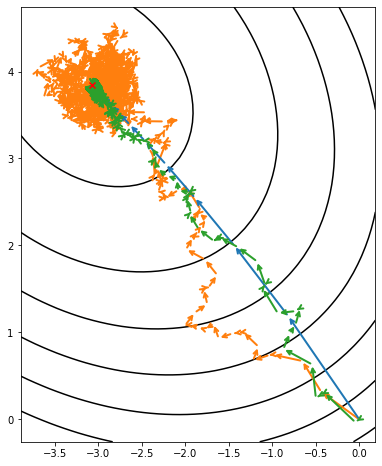

In [28]:
n = 100
f = RegularizedLeastSquaresLoss(n=n, d=2, alpha=0.0)
convergence_plot = Convergence2DPlotting(f)

sample_covariance_eigenvalues, _ = np.linalg.eigh(np.transpose(f.A) @ f.A / n)
beta = 2.0 * sample_covariance_eigenvalues[-1] + f.alpha/2.0
print("The deterministic function is", beta, "smooth")
eta = lambda t : 0.5/beta

optimizer = GradientDescent(eta = eta)
x_0 = np.array([0.0, 0.0]).reshape(2,1)
iterates = optimizer.optimize(f, x_0, n_iterations=100)

# Now run SGD.
eta = lambda t : 0.05
optimizer = GradientDescent(eta = eta)
f.stochastic_setting = True
stochastic_iterates = optimizer.optimize(f, x_0, n_iterations=1000)

# Now run SGD_{\star}.
eta = lambda t : 0.05
optimizer = SGDStar(eta = eta)
variance_reduced_iterates = optimizer.optimize(f, x_0, n_iterations=1000)

# Generate the plot.
convergence_plot.plot_iterates(stochastic_iterates, color='C1')
convergence_plot.plot_iterates(iterates, color='C0')
convergence_plot.plot_iterates(variance_reduced_iterates, color='C2')
f.stochastic_setting = False
convergence_plot.plot_contours()

## Bibliographic Remarks

The seminal work of *Nemirovsky and Yudin [1983]* has developed the theory of iteration complexity in the first-order oracle model, where the method of mirror descent was also introduced. Our presentation of convergence proofs based on potential functions (also called Lyapunov functions) was inspired by Sébastien Bubeck’s video lectures "Five Miracles of Mirror Descent" and the recent survey due to *Bansal and Gupta [2019]*. The accelerated gradient method was introduced in *Nesterov [1983]*; our presentation follows that of *Allen-
Zhu and Orecchia [2014]* and *Bansal and Gupta [2019]*, where extensions to non-Euclidean setups are also analyzed. Analysis of accelerated algorithms remains an active area of research; see the recent monograph by *d’Aspremont, Scieur, and Taylor [2021]* for further information. Our presentation of the $\text{SGD}_{\star}$ algorithm is based on the recent survey of variance-reducted methods by *Gower, Schmidt, Bach, and Richtarik [2020]*. Many important references are missing in this quick overview of the available literature. For further references consult the textbooks by *Boyd, Boyd, and Vandenberghe [2004]*, *Bubeck [2015]* and *Nesterov
[2018]*.

**References**

Z. Allen-Zhu and L. Orecchia. Linear coupling: An ultimate unification of gradient and mirror descent. arXiv preprint arXiv:1407.1537, 2014.

N. Bansal and A. Gupta. Potential-function proofs for gradient methods. Theory of Computing, 15(1):1–32, 2019.

S. Boyd, S. P. Boyd, and L. Vandenberghe. Convex optimization. Cambridge university press, 2004.

S. Bubeck. Convex optimization: Algorithms and complexity. Foundations and Trends® in Machine Learning, 8(3-4):231–357, 2015.

A. d’Aspremont, D. Scieur, and A. Taylor. arXiv:2101.09545, 2021.
Acceleration methods. arXiv preprint

R. M. Gower, M. Schmidt, F. Bach, and P. Richtarik. Variance-reduced methods for
machine learning. Proceedings of the IEEE, 108(11):1968–1983, 2020.

A. Nemirovsky and D. Yudin. Problem complexity and method efficiency in optimization. Wiley, New York, 1983.

Y. Nesterov. Lectures on convex optimization, volume 137. Springer, 2018.

Y. E. Nesterov. A method for solving the convex programming problem with convergence rate $O(1/k^2)$. In Dokl. akad. nauk Sssr, volume 269, pages 543–547, 1983.